This notebook explores the population data for elk and wolves for 1995-2019. The ratio of elk per wolf is computed and a distribution to this ratio is fitted, for validation purposes.

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from sklearn.preprocessing import StandardScaler
import scipy.stats
from scipy.optimize import curve_fit

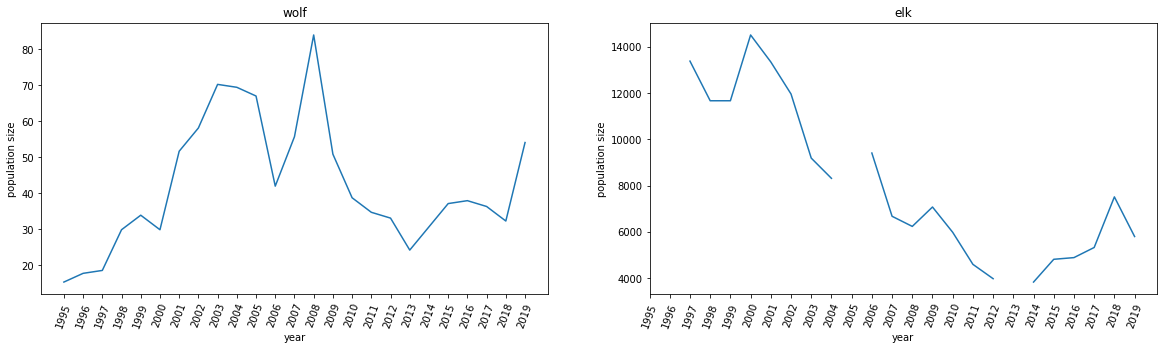

In [4]:
df = pd.read_csv('elk_wolves_pop_YSnorth.csv', sep=',')

fig,ax=plt.subplots(1,2,figsize=(20,5))
ax[0].plot(range(len(df['wolf'])), df['wolf'])
ax[0].set_title('wolf')

ax[1].plot(range(len(df['wolf'])), df['elk'])
ax[1].set_title('elk')

plt.setp(ax, xticks=range(len(df['wolf'])),
         xticklabels=np.arange(1995,2020))
plt.setp(ax, xlabel='year', ylabel='population size')
plt.setp(ax[0].xaxis.get_majorticklabels(), rotation=70)
plt.setp(ax[1].xaxis.get_majorticklabels(), rotation=70)

plt.show()

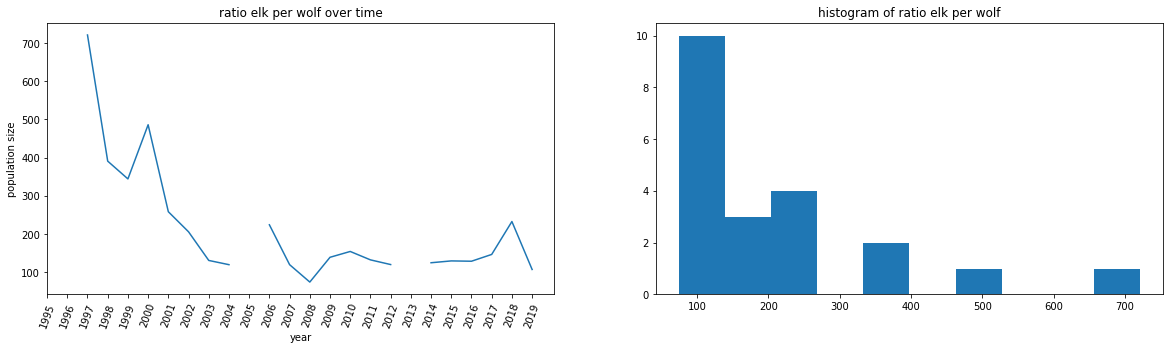

In [5]:
# Here I compute the ratio of elk per wolf over time. It is clear this ratio decreases over time and the first years
# can better be excluded. 

fig,ax=plt.subplots(1,2,figsize=(20,5))
ax[0].plot(range(len(df['wolf'])), df['elk']/df['wolf'])
ax[0].set_title('ratio elk per wolf over time')

ax[1].hist(df['elk']/df['wolf'])
ax[1].set_title('histogram of ratio elk per wolf')

plt.setp(ax[0], xticks=range(len(df['wolf'])),
         xticklabels=np.arange(1995,2020))
plt.setp(ax[0], xlabel='year', ylabel='population size')
plt.setp(ax[0].xaxis.get_majorticklabels(), rotation=70)

plt.show()

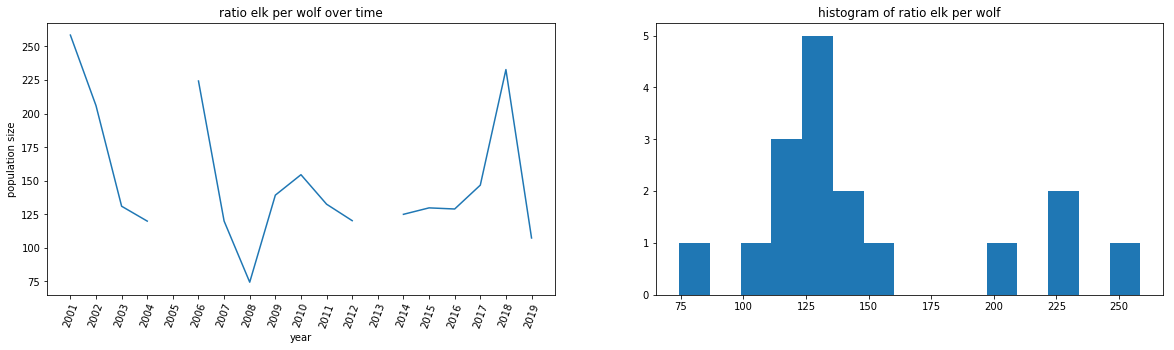

In [6]:
# the start year is a big determinant of the ratio distribution, I choose 2001 because this gives values that are 
# relatively close to each other (2000 or earlier all have much higher ratios)

start_year = 2001 # 2002 GIVES VERY DIFFERENT RESULTS, MAYBE MORE ACCURATE?

fig,ax=plt.subplots(1,2,figsize=(20,5))
ax[0].plot(range(len(df['wolf'][start_year-1995:])), df['elk'][start_year-1995:]/df['wolf'][start_year-1995:])
ax[0].set_title('ratio elk per wolf over time')

ax[1].hist(df['elk'][start_year-1995:]/df['wolf'][start_year-1995:], bins=15)
ax[1].set_title('histogram of ratio elk per wolf')

plt.setp(ax[0], xticks=range(len(df['wolf'][start_year-1995:])),
         xticklabels=np.arange(start_year,2020))
plt.setp(ax[0], xlabel='year', ylabel='population size')
plt.setp(ax[0].xaxis.get_majorticklabels(), rotation=70)

plt.show()

norm, KS: 0.24, pval: 0.26
halflogistic, KS: 0.25, pval: 0.2
logistic, KS: 0.18, pval: 0.56
maxwell, KS: 0.22, pval: 0.33
wald, KS: 0.28, pval: 0.11
rice, KS: 0.52, pval: 0.0
cauchy, KS: 0.19, pval: 0.5


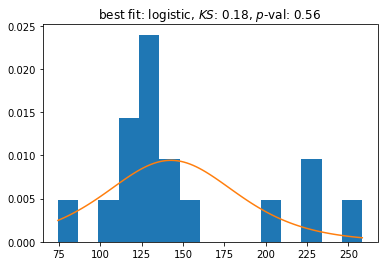

In [7]:
# I will now try fit a distribution to this data (although it is small),
# Using this distribution, we can assess whether the ratio of elk per wolf
# is natural.

ratios = (df['elk'][start_year-1995:]/df['wolf'][start_year-1995:]).dropna()

dist_names = ['norm',
              'halflogistic',
              'logistic',
              'maxwell',
              'wald',
              'rice', 
              'cauchy']

chi_square = []
p_values   = []

best_dist = 'none'
best_pval = 0.0
best_pval = 0.0
best_vals = []

for dist_name in dist_names:
    dist = getattr(scipy.stats, dist_name)
    params = dist.fit(ratios)
    
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    
    KS = scipy.stats.kstest(ratios, dist_name, args=(loc, scale))
    
    if KS[1] > best_pval:
        best_dist = dist_name
        best_KS = KS[0]
        best_pval = KS[1]
        best_vals = params
        
    print(dist_name+ ', KS: '+str(round(KS[0],2))+
          ', pval: '+str(round(KS[1],2)))
        
arg = best_vals[:-2]
loc = best_vals[-2]
scale = best_vals[-1]

dist = getattr(scipy.stats, best_dist)
        
plt.hist(ratios,density=True,bins=15)
x = np.linspace(min(ratios),max(ratios),100)
plt.plot(x, dist.pdf(x,loc=loc,scale=scale,*arg))
plt.title('best fit: '+best_dist+', $KS$: '+str(round(best_KS,2))+
          ', $p$-val: '+str(round(best_pval,2)))
plt.show()

64.56284927930444
220.75728471978164


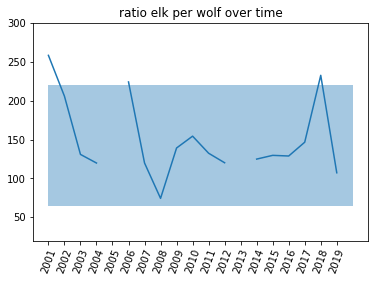

In [8]:
# Use the fitted distribution to get a confidence interval:
start_year = 2001
ratios = (df['elk'][start_year-1995:]/df['wolf'][start_year-1995:])

def inv_cdf_logistic(m,s,prob):
    return m-s*np.log(1/prob-1)

confidence_level=0.9

print(inv_cdf_logistic(loc,scale,(1-confidence_level)/2))
print(inv_cdf_logistic(loc,scale,1-(1-confidence_level)/2))

plt.plot(range(len(df['wolf'][start_year-1995:])), ratios)
plt.fill_between([0,len(ratios)], 
                 inv_cdf_logistic(loc,scale,(1-confidence_level)/2),
                 inv_cdf_logistic(loc,scale,1-(1-confidence_level)/2), 
                 alpha=0.4)
plt.title('ratio elk per wolf over time')
plt.xticks(range(len(df['wolf'][start_year-1995:])),np.arange(start_year,2020),
           rotation=70)
plt.ylim(20,300)

plt.show()

55.66456986515141
201.2819194958571


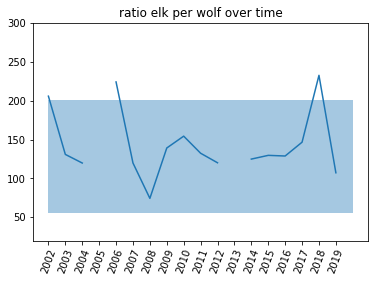

In [9]:
# Try with Cauchy distribution from 2002
start_year = 2002
ratios = (df['elk'][start_year-1995:]/df['wolf'][start_year-1995:])

dist = getattr(scipy.stats, 'cauchy')
params = dist.fit(ratios.dropna())
arg = params[:-2]
loc = params[-2]
scale = params[-1]

def inv_cdf_cauchy(m,s,prob):
    return m+s*np.tan(np.pi*(prob-1/2))

confidence_level=0.90

print(inv_cdf_cauchy(loc,scale,(1-confidence_level)/2))
print(inv_cdf_cauchy(loc,scale,1-(1-confidence_level)/2))

plt.plot(range(len(df['wolf'][start_year-1995:])), ratios)
plt.fill_between([0,len(ratios)], 
                 inv_cdf_cauchy(loc,scale,(1-confidence_level)/2),
                 inv_cdf_cauchy(loc,scale,1-(1-confidence_level)/2), 
                 alpha=0.4)
plt.title('ratio elk per wolf over time')
plt.xticks(range(len(df['wolf'][start_year-1995:])),np.arange(start_year,2020),
           rotation=70)
plt.ylim(20,300)

plt.show()

c:\users\juliu\appdata\local\programs\python\python37\lib\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


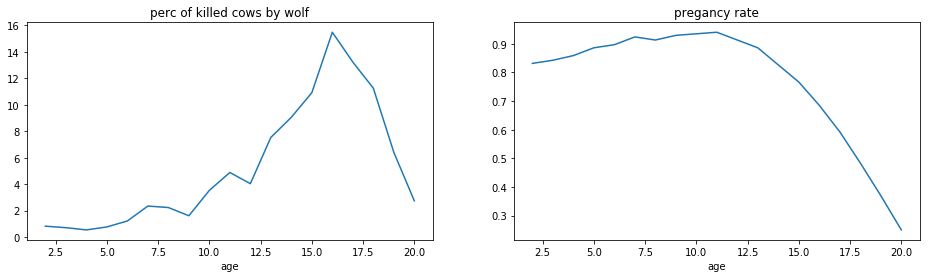

In [10]:
df = pd.read_csv('elk_deathrate_pregrate.csv')

age = df['age']
death_rate = df['perc_of_killed']
preg_rate  = df['preg_rate']

fig,ax=plt.subplots(1,2,figsize=(16,4))
ax[0].plot(age,death_rate)
ax[0].set_title('perc of killed cows by wolf')

ax[1].plot(age,preg_rate)
ax[1].set_title('pregancy rate')

plt.setp(ax, xlabel='age')

plt.show()

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


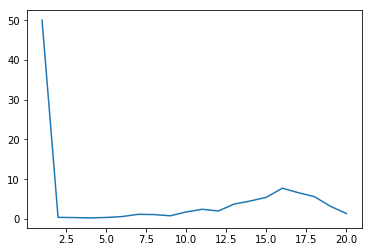

In [11]:
print(np.append([1],df['age'].values))

plt.plot(np.append([1],df['age'].values), np.append([50],(df['perc_of_killed'].values)/2))
plt.show()

[0.821206994, 1.5296108290000001, 2.068809927, 2.8336153420000003, 4.049633391, 6.393683024, 8.624929499, 10.235758602, 13.764241400000001, 18.646362099, 22.68245911, 30.215454034, 39.271291597, 50.188381277000005, 65.673998877, 78.90355330700001, 90.15905245700002, 96.56401579600002, 99.30287648400002]


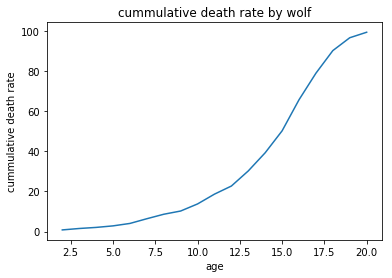

In [12]:
cumm_death_rate = [death_rate[i]+sum(death_rate[:i]) for i in range(len(death_rate))]
print(cumm_death_rate)
plt.plot(age, cumm_death_rate)
plt.title('cummulative death rate by wolf')
plt.xlabel('age')
plt.ylabel('cummulative death rate')
plt.show()

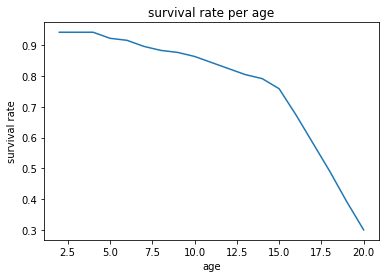

In [13]:
plt.plot(df['age'], df['surv_rate'])
plt.title('survival rate per age')
plt.xlabel('age')
plt.ylabel('survival rate')
plt.show()

1.0522885107674245


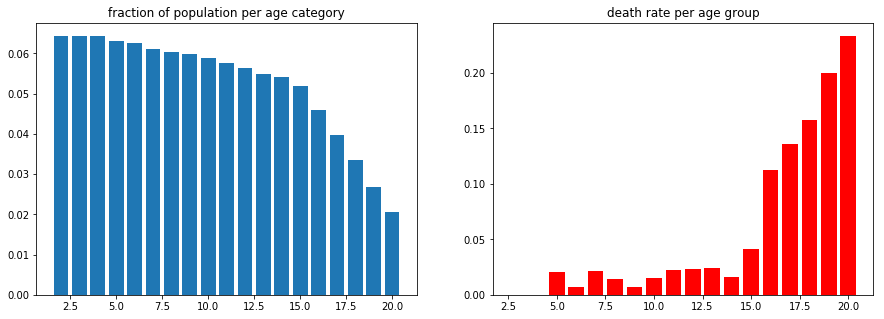

In [14]:
surv = df['surv_rate']

deaths_perc = [-(surv[i]-surv[i-1])/surv[i-1] for i in range(1, len(surv))]

fig,ax=plt.subplots(1,2,figsize=(15,5))

ax[0].bar(df['age'],surv/sum(surv))
ax[0].set_title('fraction of population per age category')

ax[1].bar(df['age'][1:], deaths_perc, color='red')
ax[1].set_title('death rate per age group')

print(sum(deaths_perc))

plt.show()

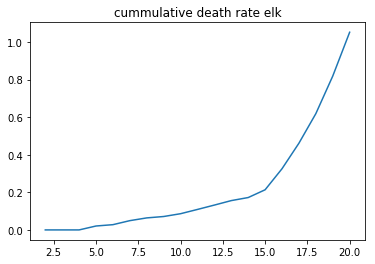

In [15]:
cumm_elk_deaths = np.array([sum(deaths_perc[:i]) for i in range(len(deaths_perc)+1)])
plt.plot(df['age'], cumm_elk_deaths)
plt.title('cummulative death rate elk')
plt.show()

total amount of annual deaths: 218.84769991514867


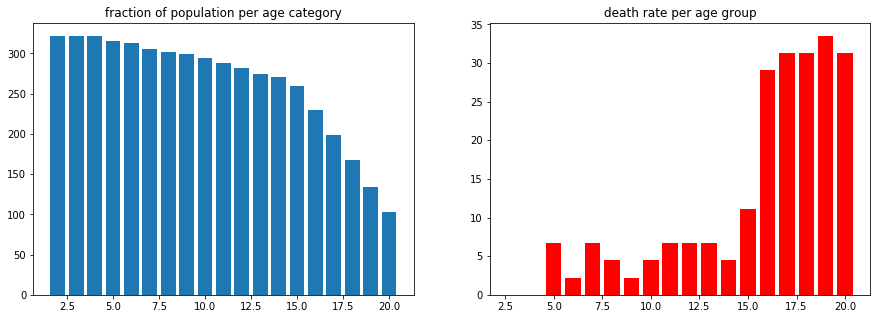

In [16]:
tot_elk_pop = 5000

# surv = tot_elk_pop*df['surv_rate']
nom_pop = surv/sum(surv)*tot_elk_pop

nom_deaths = [-(nom_pop[i]-nom_pop[i-1]) for i in range(1, len(surv))]

fig,ax=plt.subplots(1,2,figsize=(15,5))

ax[0].bar(df['age'],nom_pop)
ax[0].set_title('fraction of population per age category')

ax[1].bar(df['age'][1:], nom_deaths, color='red')
ax[1].set_title('death rate per age group')

print('total amount of annual deaths:', sum(nom_deaths))

plt.show()

Text(0, 0.5, 'perc killed')

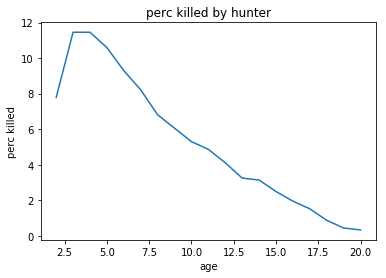

In [17]:
plt.plot(df['age'], df['hunter_perc_killed'])
plt.title('perc killed by hunter')
plt.xlabel('age')
plt.ylabel('perc killed')

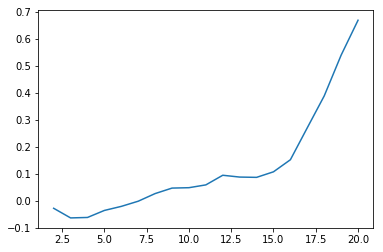

In [18]:
plt.plot(df['age'], (1-df['surv_rate'])-df['hunter_perc_killed']/100-df['perc_of_killed']/100)
plt.show()

(array([ 1.66360641,  0.17265893, -0.3173134 ]), array([[ 6.32437312e+13,  6.80771210e+04, -3.80160420e+13],
       [ 6.80771313e+04,  9.58977790e-04, -4.09214324e+04],
       [-3.80160420e+13, -4.09214264e+04,  2.28515842e+13]]))


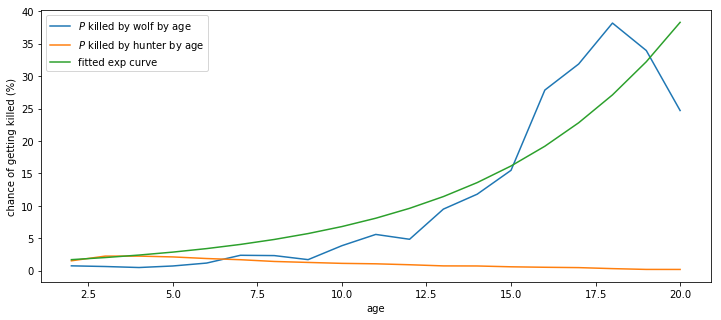

In [62]:
# I derived the following probabilities, which are likely not correct

elk_pop = 5000
wolf_pop = 50
P_kill_by_wolf = 1100/1350
P_kill_by_hunt = 250/1350

P_kill_wolf_byage = np.array([((df['perc_of_killed'][i]/df['surv_rate'][i]*P_kill_by_wolf)/df['surv_rate'][i]) for i,a in enumerate(df['age'])])
P_kill_hunt_byage = [((df['hunter_perc_killed'][i]*P_kill_by_hunt)/df['surv_rate'][i]) for i,a in enumerate(df['age'])]

def f(x,a,b,c):
    return a*np.exp(b*x+c)

param = curve_fit(f,df['age'],P_kill_wolf_byage)
print(param)

fitted_val = [f(x, param[0][0], param[0][1], param[0][2]) for x in df['age']]


fig=plt.subplots(figsize=(12,5))
plt.plot(df['age'], P_kill_wolf_byage, label='$P$ killed by wolf by age')
plt.plot(df['age'], P_kill_hunt_byage, label='$P$ killed by hunter by age')
plt.plot(df['age'], fitted_val, label='fitted exp curve')
plt.ylabel('chance of getting killed (%)')
plt.xlabel('age')
plt.legend()
plt.show() 

In [64]:
test_elk = {0:5, 1:18, 2:3, 3:3}
overall_P_kill_by_wolf = 1100/1350


def Bayes_p_kill_by_wolf(age, overall_P_kill_by_wolf):
    return (df['perc_of_killed'][age]/100*overall_P_kill_by_wolf)/df['surv_rate'][age]


def fitted_Bayes_P_kill_wolf(age, overall_P_kill_by_wolf):
    a = 1.66360641
    b = 0.17265893
    c = -0.3173134
    return a*np.exp(b*age+c)
    

def P_kill_by_wolf(animals):
    p_kills = {}     
    
    for i,age in animals.items():
        P_animal = fitted_Bayes_P_kill_wolf(age, overall_P_kill_by_wolf)
        P_all_animals = sum([fitted_Bayes_P_kill_wolf(a, overall_P_kill_by_wolf) for j,a in animals.items()])
        
        p_kills[i] = P_animal/P_all_animals
        
#     return p_kills


test_elk = {0:5, 1:18, 2:3, 3:3}
overall_P_kill_by_wolf = 1100/1350

print(P_kill_by_wolf(test_elk))

test_elk = {0:18, 1:18, 2:18, 3:3}
print(P_kill_by_wolf(test_elk))
    

{0: 0.08437173350083961, 1: 0.7961586892896035, 2: 0.0597347886047784, 3: 0.0597347886047784}
{0: 0.3252002118953076, 1: 0.3252002118953076, 2: 0.3252002118953076, 3: 0.024399364314077337}
